In [24]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
#from transformers import RobertaTokenizer, RobertaModel

from sklearn.metrics import f1_score

from torch.utils.tensorboard import SummaryWriter
from transformers import AdamW

import time
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
from deep_translator import GoogleTranslator
from googletrans import Translator
import random
import matplotlib.pyplot as plt


import os
import json
import sys

#nltk.download('wordnet')
#nltk.download('omw-1.4')

translator = Translator()


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
MAX_LEN = 100
BATCH = 32
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' #"roberta-base" #'bert-base-cased'
EPOCHS = 10
LEARNING_RATE = 0.00001
THRESHOLD = 0.2 #prog decyzyjny
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 0.001
MODE='min'
PATIENCE=2
FACTOR=0.5
VERBOSE=True

In [3]:
df_data = pd.read_csv('C:/Users/juwieczo/DataspellProjects/meisd_project/pipeline/max_first_25_intensity.csv')
#df_data = pd.read_csv('C:/Users/juwieczo/DataspellProjects/meisd_project/pipeline/balanced_augmented_data_primary_intensity.csv')

In [4]:
df_data.head()

,dialog_ids,Utterances,max_intensity
0,1,"you're cristina, right? - patton, monroe which...",3
1,2,i have five rules. memorize them rule number o...,2
2,3,"""i'm your sister, i'm your daughter."" you're s...",1
3,4,just be quick about it you're the one that's s...,2
4,5,people do wake up. that's why we do a series o...,2


In [5]:
label_frequencies = df_data['max_intensity'].value_counts()
label_frequencies_percent = df_data['max_intensity'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

max_intensity
2    46.797153
3    35.676157
1    13.345196
0     4.181495
Name: proportion, dtype: float64
max_intensity
2    526
3    401
1    150
0     47
Name: count, dtype: int64


In [6]:
df_data['label'] = (df_data['max_intensity'] == 2).astype(int)
#df_data['label'] = (df_data['label'] == 2).astype(int)

columns = ['Utterances', 'label']
df = df_data[columns].copy()

In [7]:
# 1. Synonym Replacement
def synonym_replacement(text):
    words = text.split()
    new_words = words[:]
    num_replacements = max(1, len(words) // 5)  # Replace about 20% of words
    random_words = random.sample(words, num_replacements)

    for word in random_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            #synonym = synonyms[0].lemmas()[0].name()  # Take first synonym
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:  # Avoid replacement if the synonym is identical
                new_words = [synonym if w == word else w for w in new_words]
    return ' '.join(new_words)


# 2. Random Insertion
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        new_word = random.choice(words)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, new_word)
    return ' '.join(words)


# 3. Random Deletion
def random_deletion(text, p=0.3):
    words = text.split()
    if len(words) == 1:
        return text  # Avoid deleting single-word text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if not new_words:
        return random.choice(words)  # Return one word if all words are deleted
    return ' '.join(new_words)

# 4. Back Translation
def back_translation(text, src_lang='en', mid_lang='fr', max_retries=3):
    attempt = 0
    while attempt < max_retries:
        try:
            translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
            back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
            return back_translated
        except Exception as e:
            print(f"Back translation error on attempt {attempt + 1}: {e}")
            attempt += 1
            time.sleep(1)
    raise ValueError("Back translation failed")

In [8]:
def augment_text(text, num_augments=2):
    augmented_texts = []
    for _ in range(num_augments):
        augmentation_choice = random.choice(['synonym', 'insertion', 'deletion', 'back_translation'])
        if augmentation_choice == 'synonym':
            augmented_texts.append(synonym_replacement(text))
        elif augmentation_choice == 'insertion':
            augmented_texts.append(random_insertion(text))
        elif augmentation_choice == 'deletion':
            augmented_texts.append(random_deletion(text))
        elif augmentation_choice == 'back_translation':
            augmented_texts.append(back_translation(text))
    return augmented_texts

In [9]:
from tqdm import tqdm
import pandas as pd

def augment_binary_data(df, label_column, augment_text, num_augments=2):
    """
    Augments binary classification data to balance class distributions.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterances' column and a binary label column.
    - label_column (str): Column name of the binary target label (0 or 1).
    - augment_text (callable): Function to augment text. Should take a string and return a list of augmented strings.
    - num_augments (int): Number of augmented samples to generate per original sample.

    Returns:
    - pd.DataFrame: Augmented DataFrame with balanced class distribution.
    """
    # Oblicz liczność klas
    class_counts = df[label_column].value_counts()
    min_class, max_class = class_counts.idxmin(), class_counts.idxmax()
    num_min, num_max = class_counts[min_class], class_counts[max_class]

    print(f"Liczność klas przed augmentacją: {class_counts.to_dict()}")

    # Pobierz próbki z mniejszej klasy
    class_subset = df[df[label_column] == min_class].copy()

    # Oblicz ile dodatkowych próbek potrzebujemy
    num_to_add = num_max - num_min

    # Inicjalizacja nowego zbioru danych
    augmented_data = {'Utterances': [], label_column: []}

    # Augmentuj dane, ale tylko do momentu wyrównania liczby próbek
    augment_per_sample = max(1, num_to_add // len(class_subset))  # Ile augmentacji na 1 próbkę
    remaining = num_to_add  # Ile jeszcze próbek musimy dodać

    for _, row in tqdm(class_subset.iterrows(), total=len(class_subset), desc=f"Augmenting class {min_class}"):
        if remaining <= 0:
            break

        # Wykonaj augmentację tekstu
        new_texts = augment_text(row['Utterances'], num_augments=min(augment_per_sample, remaining))

        for new_text in new_texts:
            if remaining <= 0:
                break
            augmented_data['Utterances'].append(new_text)
            augmented_data[label_column].append(min_class)
            remaining -= 1  # Zmniejsz licznik brakujących próbek

    # Tworzenie DataFrame z nowymi próbkami
    augmented_df = pd.DataFrame(augmented_data)

    # Połączenie oryginalnych danych z nowymi danymi
    final_df = pd.concat([df, augmented_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

    # Sprawdź finalny rozkład klas
    final_counts = final_df[label_column].value_counts()
    print(f"Liczność klas po augmentacji: {final_counts.to_dict()}")

    return final_df


In [10]:
from tqdm import tqdm
import pandas as pd

def augment_binary_data_percent(df, label_column, augment_text, augment_percent=25):
    """
    Augments binary classification data by a specified percentage.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterances' column and a binary label column.
    - label_column (str): Column name of the binary target label (0 or 1).
    - augment_text (callable): Function to augment text. Should take a string and return a list of augmented strings.
    - augment_percent (int): Percentage increase for each class (e.g., 25 means adding 25% more samples per class).

    Returns:
    - pd.DataFrame: Augmented DataFrame with increased class distributions.
    """
    # Oblicz liczność klas
    class_counts = df[label_column].value_counts()
    print(f"Liczność klas przed augmentacją: {class_counts.to_dict()}")

    # Inicjalizacja nowego zbioru danych
    augmented_data = {'Utterances': [], label_column: []}

    for label in class_counts.index:
        class_subset = df[df[label_column] == label].copy()
        num_to_add = int(class_counts[label] * (augment_percent / 100))

        augment_per_sample = max(1, num_to_add // len(class_subset))
        remaining = num_to_add

        for _, row in tqdm(class_subset.iterrows(), total=len(class_subset), desc=f"Augmenting class {label}"):
            if remaining <= 0:
                break

            new_texts = augment_text(row['Utterances'], num_augments=min(augment_per_sample, remaining))

            for new_text in new_texts:
                if remaining <= 0:
                    break
                augmented_data['Utterances'].append(new_text)
                augmented_data[label_column].append(label)
                remaining -= 1

    # Tworzenie DataFrame z nowymi próbkami
    augmented_df = pd.DataFrame(augmented_data)

    # Połączenie oryginalnych danych z nowymi danymi
    final_df = pd.concat([df, augmented_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

    # Sprawdź finalny rozkład klas
    final_counts = final_df[label_column].value_counts()
    print(f"Liczność klas po augmentacji: {final_counts.to_dict()}")

    return final_df


In [11]:
## Augmentation
augmented_df = augment_binary_data(
    df=df,
    label_column='label',
    augment_text=augment_text,
    num_augments=2
)

print(augmented_df)

Liczność klas przed augmentacją: {0: 598, 1: 526}


Augmenting class 1:  14%|█▎        | 72/526 [00:45<04:44,  1.60it/s]

Liczność klas po augmentacji: {1: 598, 0: 598}
                                             Utterances  label
0                                    I just saw Janice.      1
1     um sorry. his legs what about them? they're bo...      1
2     thank you. - i thought you loved cardio no, no...      0
3     i was shocked to realize the degree to which y...      0
4     they're dangerous, capricious tricksters who a...      1
...                                                 ...    ...
1191  what about this woman? did you ever see her? p...      0
1192  but skorsky's saying her source believes the m...      1
1193  Sorry. Me, uh ... I'm not sorry to have just ....      1
1194  Oh, ain't that nice? The three of you trying o...      1
1195  oh! i see why you're confused. no her news sou...      0

[1196 rows x 2 columns]


In [12]:
df = augment_binary_data_percent(
    df=augmented_df,
    label_column='label',
    augment_text=augment_text,
    augment_percent=70
)

print(df)

Liczność klas przed augmentacją: {1: 598, 0: 598}


Augmenting class 0:  70%|██████▉   | 418/598 [04:41<02:01,  1.48it/s]

Liczność klas po augmentacji: {0: 1016, 1: 1016}
                                             Utterances  label
0     unbelievable. who would to wasn't in prison, y...      0
1     plural, bitch you did not have my permission a...      0
2     And the horrors she's had to endure... Losing ...      1
3     he's evil he didn't sabotage your interview ho...      1
4     No, its okay. Some-some kid asked me to pick ...      0
...                                                 ...    ...
2027  hey, person call jay leno we got the world's d...      0
2028                                             Hello?      0
2029  And y'know the other one over there, that's th...      0
2030  Why did she leave their place? - She always le...      1
2031  Ah, ladies love the bad boys mm cesar <i> "el ...      0

[2032 rows x 2 columns]


In [13]:
label_frequencies = df['label'].value_counts()
label_frequencies_percent = df['label'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

label
0    50.0
1    50.0
Name: proportion, dtype: float64
label
0    1016
1    1016
Name: count, dtype: int64


In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [15]:
print(f"Original train size: {df_data.shape}")
print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

Original train size: (1124, 4)
Validation size: (305, 2), Test size: (305, 2)


In [16]:
df.head()

,Utterances,label
0,"unbelievable. who would to wasn't in prison, y...",0
1,"plural, bitch you did not have my permission a...",0
2,And the horrors she's had to endure... Losing ...,1
3,he's evil he didn't sabotage your interview ho...,1
4,"No, its okay. Some-some kid asked me to pick ...",0


In [17]:
label_frequencies = df['label'].value_counts()
label_frequencies_percent = df['label'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

label
0    50.0
1    50.0
Name: proportion, dtype: float64
label
0    1016
1    1016
Name: count, dtype: int64


In [18]:
class_distribution = df['label'].value_counts(normalize=True)
print(class_distribution)

label
0    0.5
1    0.5
Name: proportion, dtype: float64


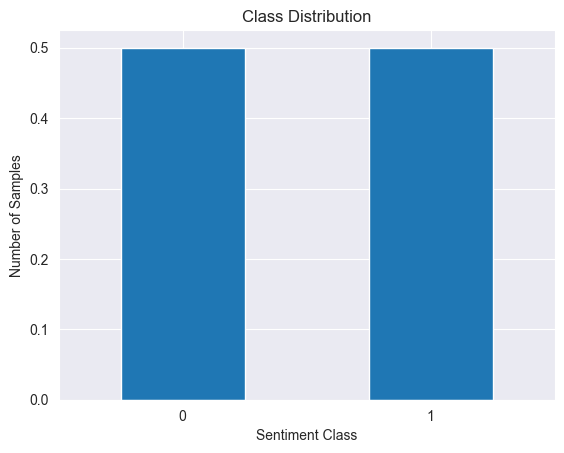

In [19]:
import matplotlib.pyplot as plt
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

In [20]:
target_list = list(df.columns)
target_list = target_list[1:]
target_list

['label']

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        self.targets = self.df['label'].astype(int).values
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        target = torch.tensor(self.targets[index], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            #'token_type_ids': inputs["token_type_ids"].flatten(), -> nie potrzebne przy RoBERTa
            'targets': torch.tensor(self.targets[index], dtype=torch.long),
            'utterances': utterances
        }

In [22]:
class BERTBinarySentimentClassificationClass(nn.Module):
    def __init__(self, bert_model):
        super(BERTBinarySentimentClassificationClass, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)  # Binary classification (1 output)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Forward pass przez BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        return self.out(dropout_output)
        #return torch.sigmoid(self.out(dropout_output))

In [23]:
# class RoBERTaBinarySentimentClassificationClass(nn.Module):
#     def __init__(self, roberta_model):
#         super(RoBERTaBinarySentimentClassificationClass, self).__init__()
#         self.roberta = roberta_model
#         self.dropout = nn.Dropout(p=DROPOUT_RATE)
#         self.out = nn.Linear(self.roberta.config.hidden_size, 1)  # Binary classification
# 
#     def forward(self, input_ids, attention_mask):
#         # Forward pass przez RoBERTa
#         outputs = self.roberta(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
#         # Sprawdzenie, czy pooler_output jest dostępne
#         if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
#             pooled_output = outputs.pooler_output  # Preferowane, jeśli dostępne
#         else:
#             pooled_output = outputs.last_hidden_state[:, 0, :]  # Wykorzystanie tokena [CLS]
# 
#         dropout_output = self.dropout(pooled_output)
#         return self.out(dropout_output)
#         # return torch.sigmoid(self.out(dropout_output))  # Jeśli używasz BCEWithLogitsLoss, sigmoid nie jest potrzebny

In [25]:
#model_path = 'best_model_state.bin'
bert_model = BertModel.from_pretrained("bert-base-uncased")
model = BERTBinarySentimentClassificationClass(bert_model)


# roberta_model = RobertaModel.from_pretrained("roberta-base")
# model = RoBERTaBinarySentimentClassificationClass(roberta_model)


#model.load_state_dict(torch.load(model_path))
model.to(device)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


In [27]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN)

In [28]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

In [29]:
data = next(iter(train_data_loader))
outputs = model(data["input_ids"], attention_mask=data["attention_mask"])
print(outputs)

tensor([[ 0.3462],
        [ 0.2921],
        [ 0.7553],
        [ 0.3867],
        [ 0.2655],
        [ 0.0874],
        [ 0.6693],
        [ 0.2125],
        [ 0.2974],
        [-0.0148],
        [ 0.4685],
        [ 0.2135],
        [ 0.4232],
        [ 0.3426],
        [ 0.6051],
        [ 0.5708],
        [ 0.3408],
        [ 0.4543],
        [ 0.1383],
        [ 0.2395],
        [ 0.5430],
        [ 0.1790],
        [ 0.7461],
        [ 0.5282],
        [ 0.4143],
        [ 0.2197],
        [ 0.1922],
        [ 0.0116],
        [ 0.3328],
        [ 0.4491],
        [ 0.4760],
        [ 0.0804]], grad_fn=<AddmmBackward0>)


In [30]:
test_text = "We are testing BERT tokenizer."
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")

In [31]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
    input_ids=encodings['input_ids'],
    attention_mask=encodings['attention_mask']
)

In [32]:
# def loss_fn(outputs, targets):
#     # jesli uzywamy BCEWithLogitsLoss, to w modelu nie musimy dodawać sigmoid, bo ta funkcja już zawiera operację sigmoid.
#     return torch.nn.BCEWithLogitsLoss()(outputs.squeeze(-1), targets.float())

# def loss_fn(outputs, targets):
#     return torch.nn.BCELoss()(outputs.squeeze(), targets.float())

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        # inputs powinny być wyjściem z modelu (logity)
        bce_loss = self.bce(inputs, targets.float())
        probas = torch.sigmoid(inputs)
        # Obliczenie p_t: dla próbki z target=1 mamy probas, dla target=0 mamy 1 - probas
        p_t = targets * probas + (1 - targets) * (1 - probas)
        loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
        
loss_fn = FocalLoss(alpha=1, gamma=2, reduction='mean')

In [33]:
writer = SummaryWriter(log_dir='logs')

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# learning rate scheduler
# ReduceLROnPlateau może obniżać lr do bardzo małych wartości, co czasem prowadzi do problemów. Możesz dodać min_lr, aby ograniczyć ten efekt:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=MODE, patience=PATIENCE, factor=FACTOR, verbose=VERBOSE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

C:\Users\juwieczo\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
def train_model(training_loader, model, optimizer):
    """
    Trenuje model na danych treningowych i zwraca model, dokładność, średni loss oraz F1-score.

    Args:
        training_loader (DataLoader): DataLoader z danymi treningowymi.
        model (torch.nn.Module): Model do trenowania.
        optimizer (torch.optim.Optimizer): Optymalizator do aktualizacji wag modelu.
        loss_fn (callable): Funkcja strat, np. nn.BCEWithLogitsLoss.

    Returns:
        model (torch.nn.Module): Wytrenowany model.
        train_accuracy (float): Dokładność modelu na zbiorze treningowym.
        avg_loss (float): Średnia wartość funkcji strat.
        train_f1 (float): F1-score (binary) na zbiorze treningowym.
    """
    # Inicjalizacja zmiennych do śledzenia wyników
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.train()

    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)  # Binary targets jako float

        #outputs = model(ids, mask, token_type_ids if 'token_type_ids' in data else None)
        outputs = model(ids, mask if 'token_type_ids' in data else None)

        outputs = outputs.squeeze(-1)  # Dopasowanie wymiarów do binary classification (1D)

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        preds = torch.sigmoid(outputs) >= 0.5  # Sigmoid + progowanie przy 0.5
        correct_predictions += torch.sum(preds == targets).item()
        num_samples += targets.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        loop.set_postfix(batch_loss=loss.item())

    train_f1 = f1_score(all_labels, all_preds, average='binary')

    return model, correct_predictions / num_samples, np.mean(losses), train_f1

In [35]:
def eval_model(validation_loader, model, epoch):
    """
    Ewaluacja modelu na danych walidacyjnych.

    Args:
        validation_loader (DataLoader): DataLoader z danymi walidacyjnymi.
        model (torch.nn.Module): Model do oceny.
        loss_fn (callable): Funkcja strat, np. nn.BCEWithLogitsLoss.
        epoch (int): Aktualny numer epoki do logowania w TensorBoard.

    Returns:
        val_accuracy (float): Dokładność modelu na zbiorze walidacyjnym.
        avg_loss (float): Średnia wartość funkcji strat na zbiorze walidacyjnym.
        val_f1 (float): F1-score (binary) na zbiorze walidacyjnym.
    """
    # Inicjalizacja zmiennych do śledzenia wyników
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    # Ustaw model w tryb ewaluacyjny
    model.eval()

    # Wyłącz gradienty dla ewaluacji
    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)  # Binary targets jako float

            #outputs = model(ids, mask, token_type_ids if 'token_type_ids' in data else None)
            outputs = model(ids, mask if 'token_type_ids' in data else None)

            outputs = outputs.squeeze(-1)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            preds = torch.sigmoid(outputs) >= 0.5  # Sigmoid + progowanie przy 0.5
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = np.mean(losses)
    val_f1 = f1_score(all_labels, all_preds, average='binary')

    writer.add_scalar('Loss/validation', avg_loss, epoch)
    writer.add_scalar('F1-Score/validation', val_f1, epoch)

    return correct_predictions / num_samples, avg_loss, val_f1


In [36]:
history = defaultdict(list)
best_f1 = 0
patience_counter = 0


for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss, train_f1 = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f} | Train F1 {train_f1:.4f}')

    val_acc, val_loss, val_f1 = eval_model(val_data_loader, model, epoch)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}')

    # Logowanie metryk do TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('F1-Score/train', train_f1, epoch)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # Sprawdzenie najlepszej F1 i zapisanie modelu
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_binary_model_state.bin")
        best_f1 = val_f1
        print("Saved new best model.")

    #scheduler.step(val_loss)  # Tuning LR
    scheduler.step()

writer.close()

Epoch 1/10


  0%|          | 0/45 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Train loss 0.7008 | Train accuracy 0.5105 | Train F1 0.5167
Val loss 0.6900 | Val accuracy 0.5311 | Val F1 0.6651
Saved new best model.
Epoch 2/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.6922 | Train accuracy 0.5331 | Train F1 0.5985
Val loss 0.6913 | Val accuracy 0.5410 | Val F1 0.6133
Epoch 3/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.6868 | Train accuracy 0.5506 | Train F1 0.5917
Val loss 0.6906 | Val accuracy 0.5508 | Val F1 0.6532
Epoch 4/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.6679 | Train accuracy 0.5928 | Train F1 0.6459
Val loss 0.7224 | Val accuracy 0.5246 | Val F1 0.6620
Epoch 5/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.6400 | Train accuracy 0.6491 | Train F1 0.6649
Val loss 0.7648 | Val accuracy 0.5344 | Val F1 0.6698
Saved new best model.
Epoch 6/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.6054 | Train accuracy 0.6899 | Train F1 0.6969
Val loss 0.7232 | Val accuracy 0.5803 | Val F1 0.6559
Epoch 7/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.5602 | Train accuracy 0.7342 | Train F1 0.7371
Val loss 0.7200 | Val accuracy 0.6033 | Val F1 0.6300
Epoch 8/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.5269 | Train accuracy 0.7616 | Train F1 0.7563
Val loss 0.7931 | Val accuracy 0.5672 | Val F1 0.6700
Saved new best model.
Epoch 9/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.5078 | Train accuracy 0.7764 | Train F1 0.7735
Val loss 0.7632 | Val accuracy 0.6033 | Val F1 0.6790
Saved new best model.
Epoch 10/10


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss 0.4945 | Train accuracy 0.7855 | Train F1 0.7848
Val loss 0.7420 | Val accuracy 0.6197 | Val F1 0.6742


# Transfer learinng to ESConv dataset

In [37]:
def load_data(file_path):
    with open(file_path, "r", encoding='utf-8') as file:
        data = json.load(file)
    return data

#dataset = load_data("D:/julixus/MEISD/meisd_project/data/ESConv.json")
dataset = load_data("C:/Users/juwieczo/DataspellProjects/meisd_project/data/ESConv.json")

In [38]:
def extract_seeker_data(data, key):
    result = []

    for entry in data:
        dialog = entry['dialog']
        seeker_dialog = [item['content'].strip() for item in dialog if item['speaker'] == 'seeker']

        quarter_length = max(1, len(seeker_dialog) // 4)

        if key == 'initial_emotion_intensity':
            selected_dialog = seeker_dialog[:quarter_length]
        elif key == 'final_emotion_intensity':
            selected_dialog = seeker_dialog[-quarter_length:]
        else:
            continue

        result.append({
            key: entry['survey_score']['seeker'][key],
            'dialog': selected_dialog
        })

    return result

first_25_percent = extract_seeker_data(dataset, 'initial_emotion_intensity')
#last_25_percent = extract_seeker_data(dataset, 'final_emotion_intensity')

first_25_df = pd.DataFrame(first_25_percent)
#last_25_df = pd.DataFrame(last_25_percent)

first_25_df.head()

,initial_emotion_intensity,dialog
0,5,"[Hello, I am having a lot of anxiety about qui..."
1,5,"[hello im looking for someone to talk to, im f..."
2,4,"[Hello, I'm concerned about my job. I have bee..."
3,4,"[I am dong good. You?, I have been staying hom..."
4,5,"[Infinitely complicated., Too many decisions. ..."


In [39]:
label_counts = first_25_df['initial_emotion_intensity'].value_counts()
least_common_label = label_counts.idxmin()
first_25_df = first_25_df[first_25_df['initial_emotion_intensity'] != least_common_label]
first_25_df['initial_emotion_intensity'] = pd.to_numeric(first_25_df['initial_emotion_intensity'], errors='coerce')
first_25_df['initial_emotion_intensity'] = first_25_df['initial_emotion_intensity'] - 2

In [40]:
first_25_df.rename(columns={
    'dialog': 'Utterances',
    'initial_emotion_intensity': 'label'
})

,label,Utterances
0,3,"[Hello, I am having a lot of anxiety about qui..."
1,3,"[hello im looking for someone to talk to, im f..."
2,2,"[Hello, I'm concerned about my job. I have bee..."
3,2,"[I am dong good. You?, I have been staying hom..."
4,3,"[Infinitely complicated., Too many decisions. ..."
...,...,...
1295,3,"[I feel sleepy but can not sleep, It has alway..."
1296,2,"[I am fine. thanks. how about you ?, I lost my..."
1297,1,"[HI how are you today, Doing well, thanks.]"
1298,1,"[Hello, I am a little down today. How are you..."


In [41]:
df_data['label'] = (df_data['max_intensity'] == 2).astype(int)
columns = ['Utterances', 'label']
df = df_data[columns].copy()

In [42]:
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

In [43]:
def test_model(data_loader, model):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            #outputs = model(input_ids=input_ids)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Run validation
predictions, true_labels = test_model(val_data_loader, model)

# Calculate metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.48      1.00      0.64       145
           1       0.00      0.00      0.00       160

    accuracy                           0.48       305
   macro avg       0.24      0.50      0.32       305
weighted avg       0.23      0.48      0.31       305


C:\Users\juwieczo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\juwieczo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\juwieczo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av